# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

!pip install category_encoders
!pip install lightgbm
!pip install xgboost
!pip install catboost
!pip install seaborn

!conda update seaborn
!pip install seaborn --upgrade

In [1]:
!pip install category_encoders

     |████████████████████████████████| 81 kB 1.5 MB/s eta 0:00:01


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder

from time import time
from tqdm import tqdm
import asyncio
import tqdm.asyncio

pd.options.display.max_columns = None # полностью отображаем столбцы
from sklearn.model_selection import RandomizedSearchCV

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')

except:
    data = pd.read_csv('W:/Anaconda/Data Science/datasets/autos.csv')

In [4]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
print('Дубликаты:',data.duplicated().sum())

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

In [8]:
print('Дубликаты:',data.duplicated().sum())

**Описание признаков:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**  
- Price — цена (евро)

Колонки `RegistrationYear` и `RegistrationMonth` отавлю без изменения, т.к. данные в них пригодятся для машинного обучения, остальные колонки, содержащие даты, переведу в формат даты.

In [9]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data[col] = pd.to_datetime(data[col], format='%Y-%m-%d %H:%M:%S')

In [10]:
data.info()

In [11]:
# создам списки колонок, для последующего их анализа
num_cols = []
date_cols = []
cat_cols = []

for i in range(len(data.columns)):
    if data.dtypes[i] == 'int64':
        num_cols.append(data.columns[i])
    elif data.dtypes[i] == 'datetime64[ns]':
        date_cols.append(data.columns[i])
    else:
        cat_cols.append(data.columns[i])
        
print('Числовые:',num_cols, '\n','Дата:', date_cols, '\n','Категориальные:', cat_cols)

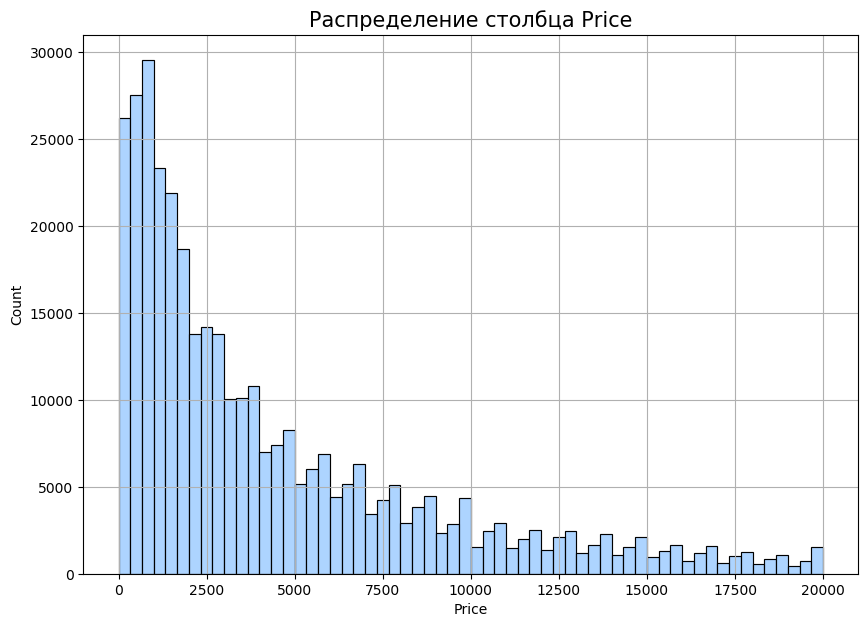

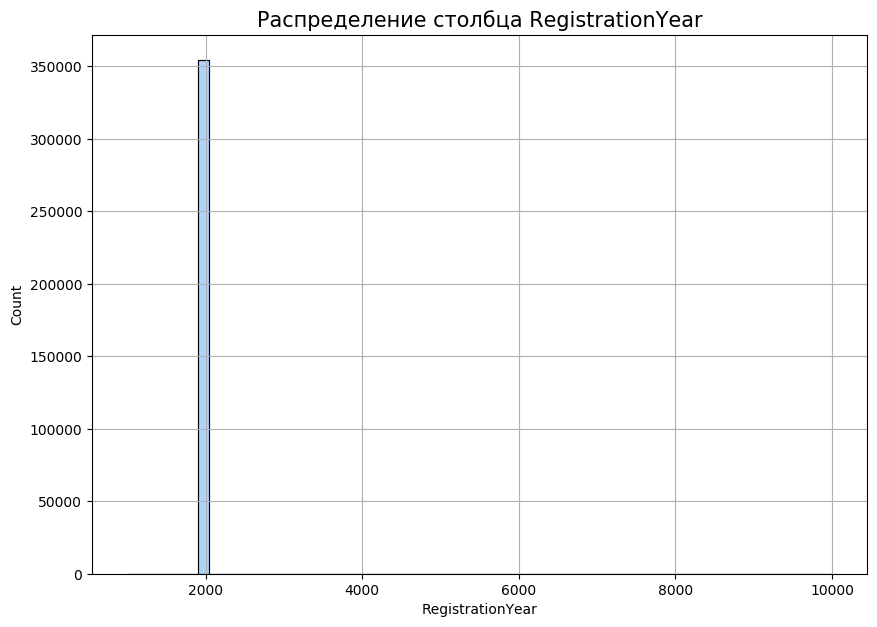

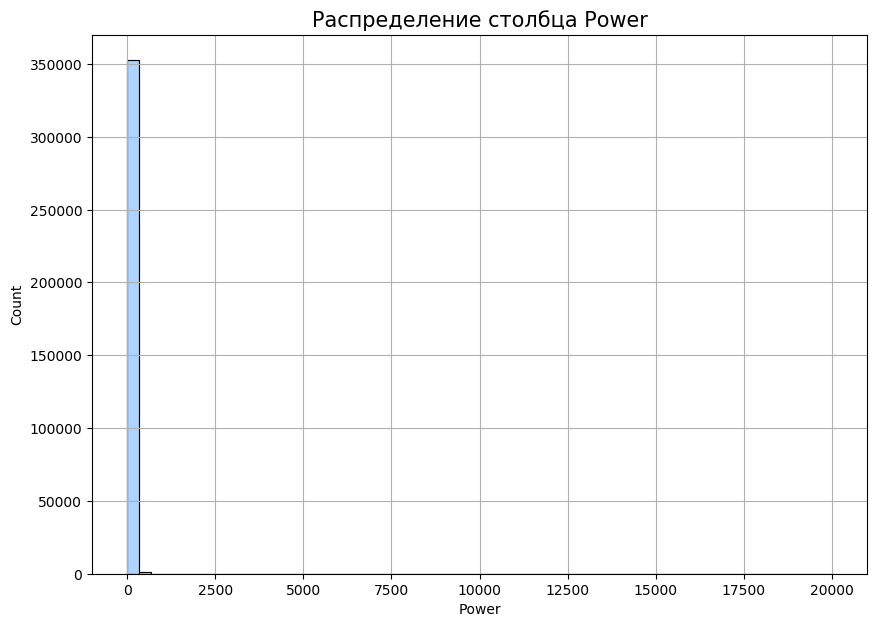

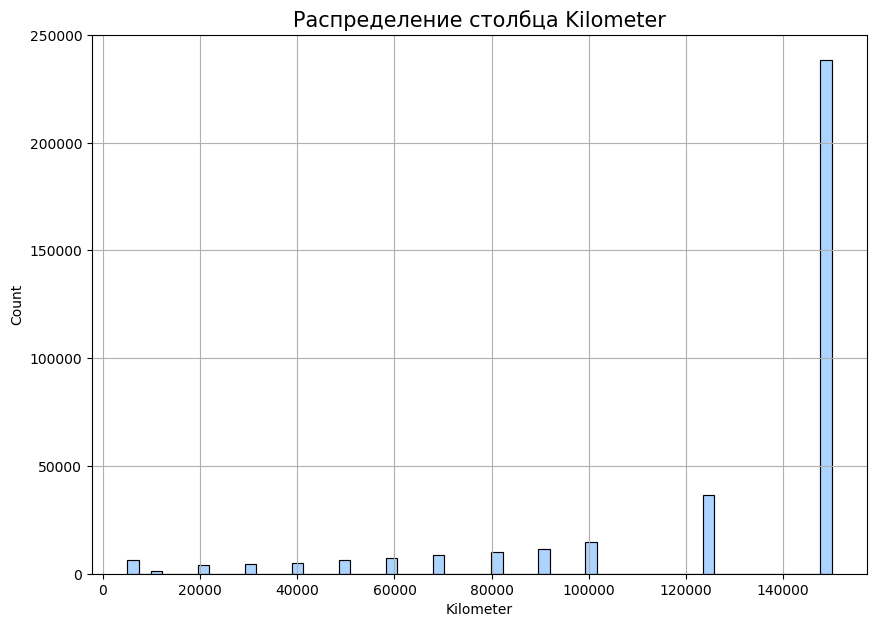

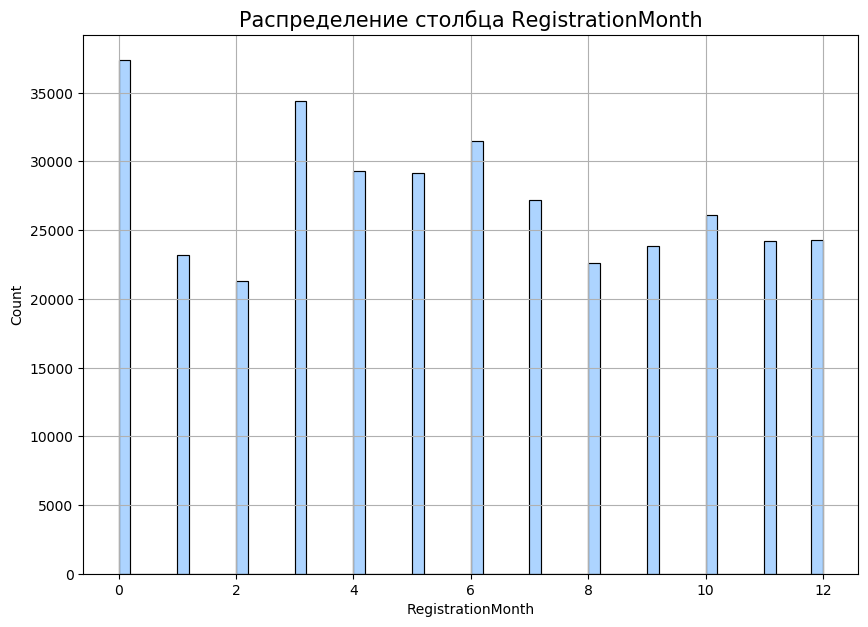

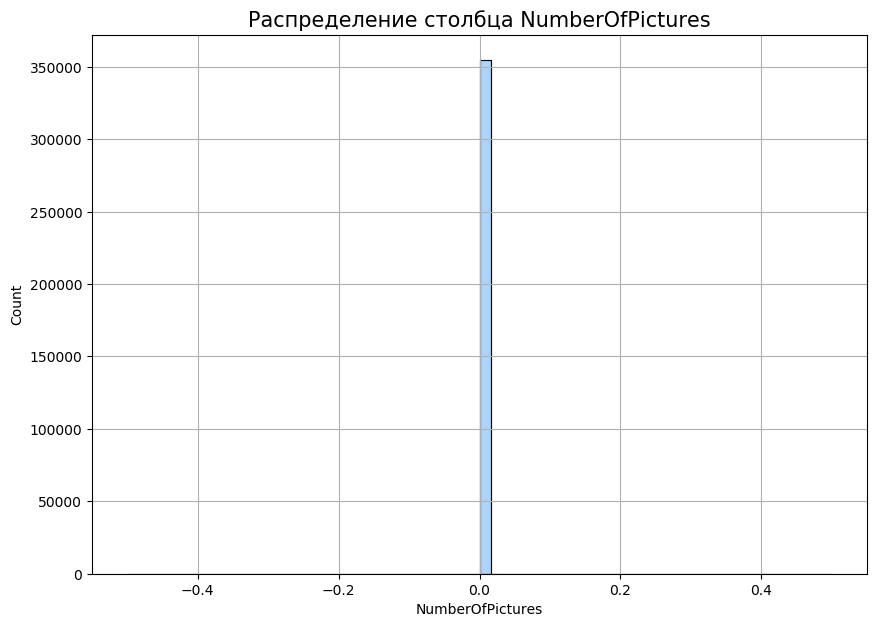

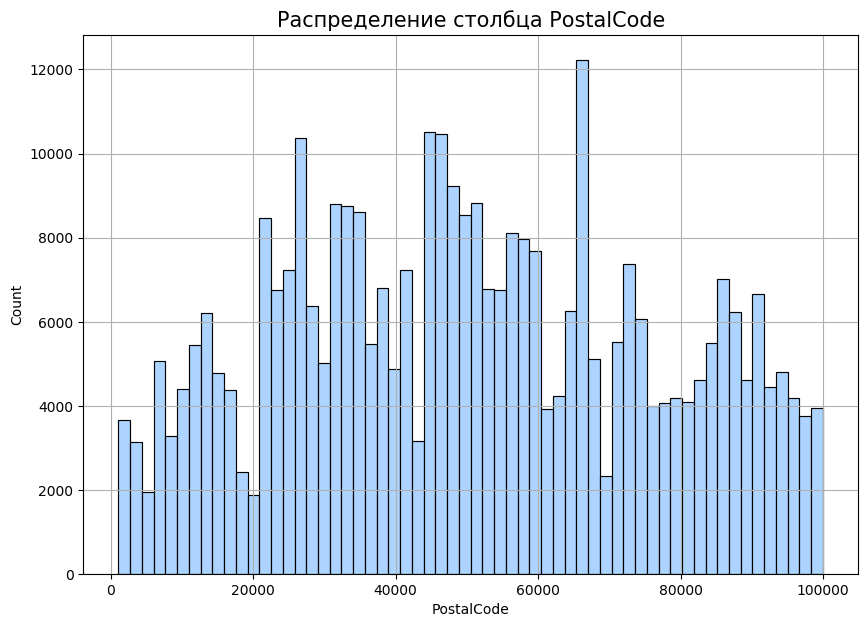

In [12]:
for col in num_cols:
    plt.figure(figsize=(10, 7)) 
    sns.histplot(data=data[col], bins = 60, edgecolor='k')
    plt.title(f'Распределение столбца {col}',fontsize=15)
    plt.grid()
    plt.show()

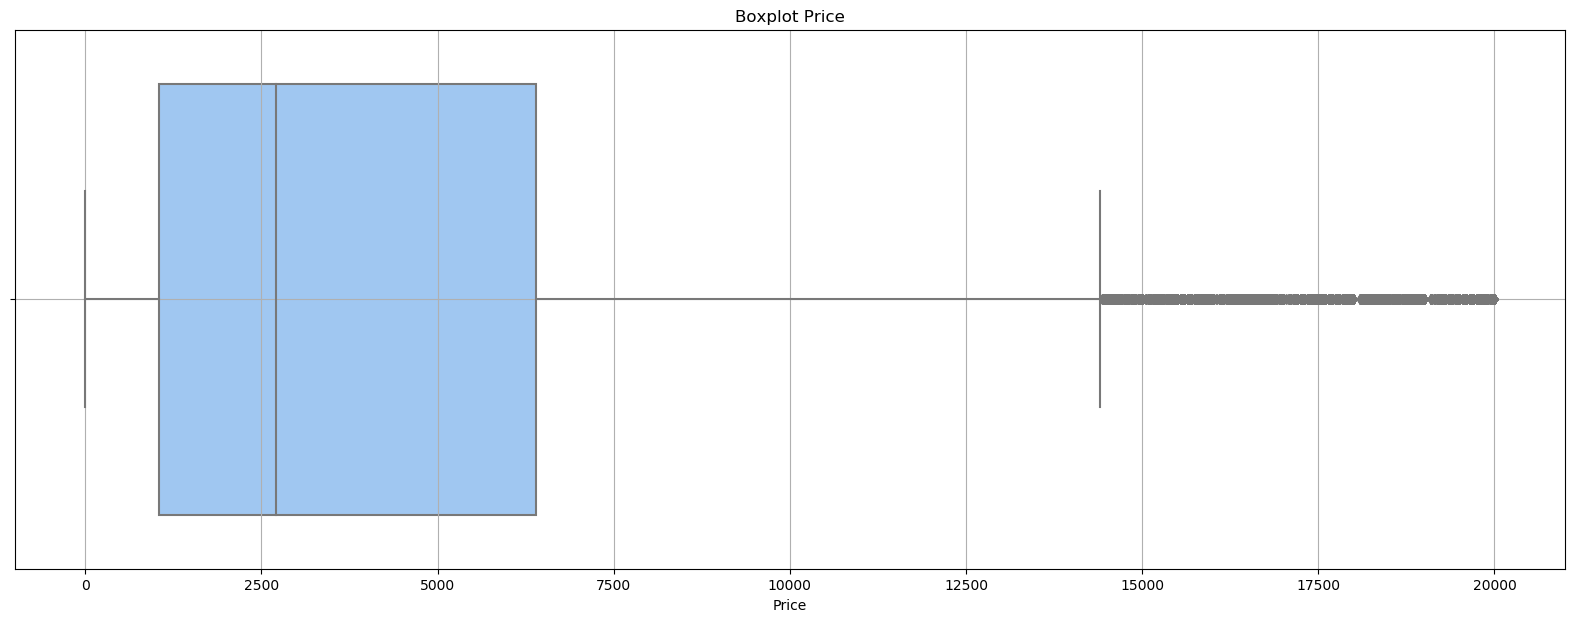

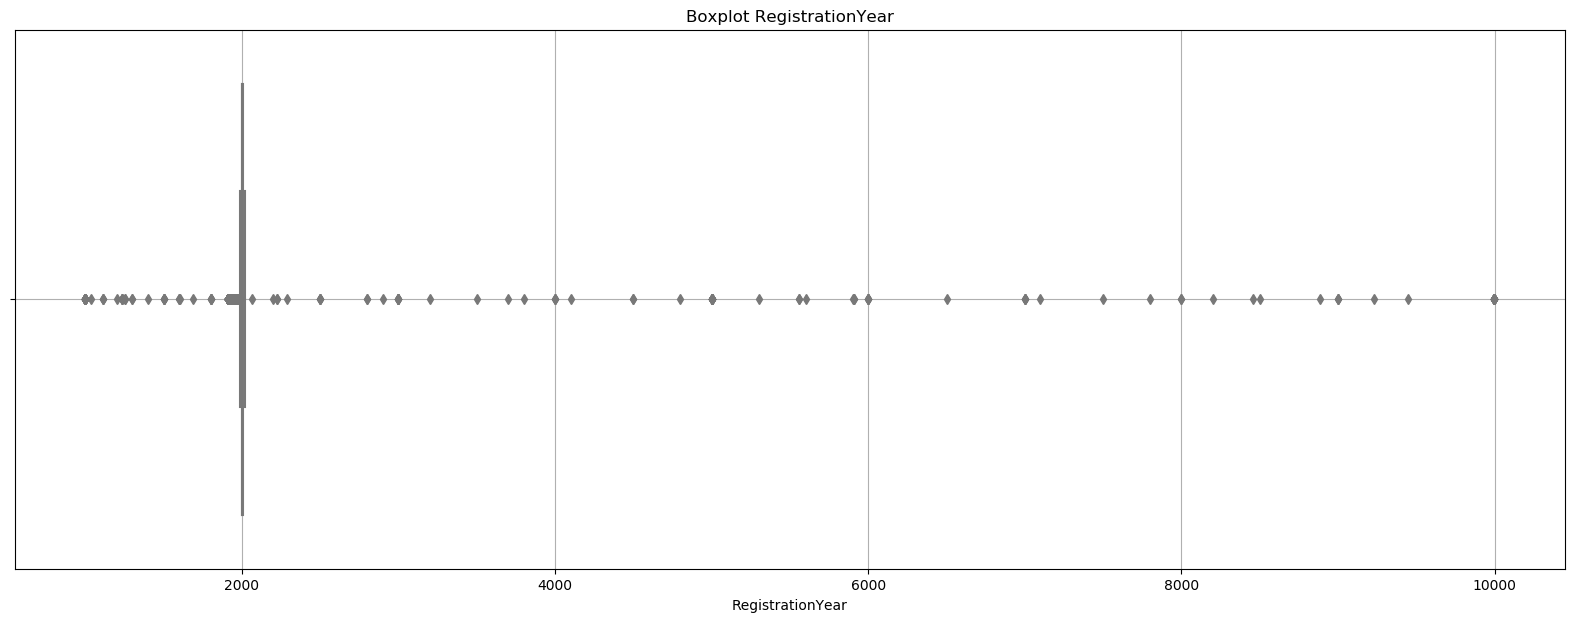

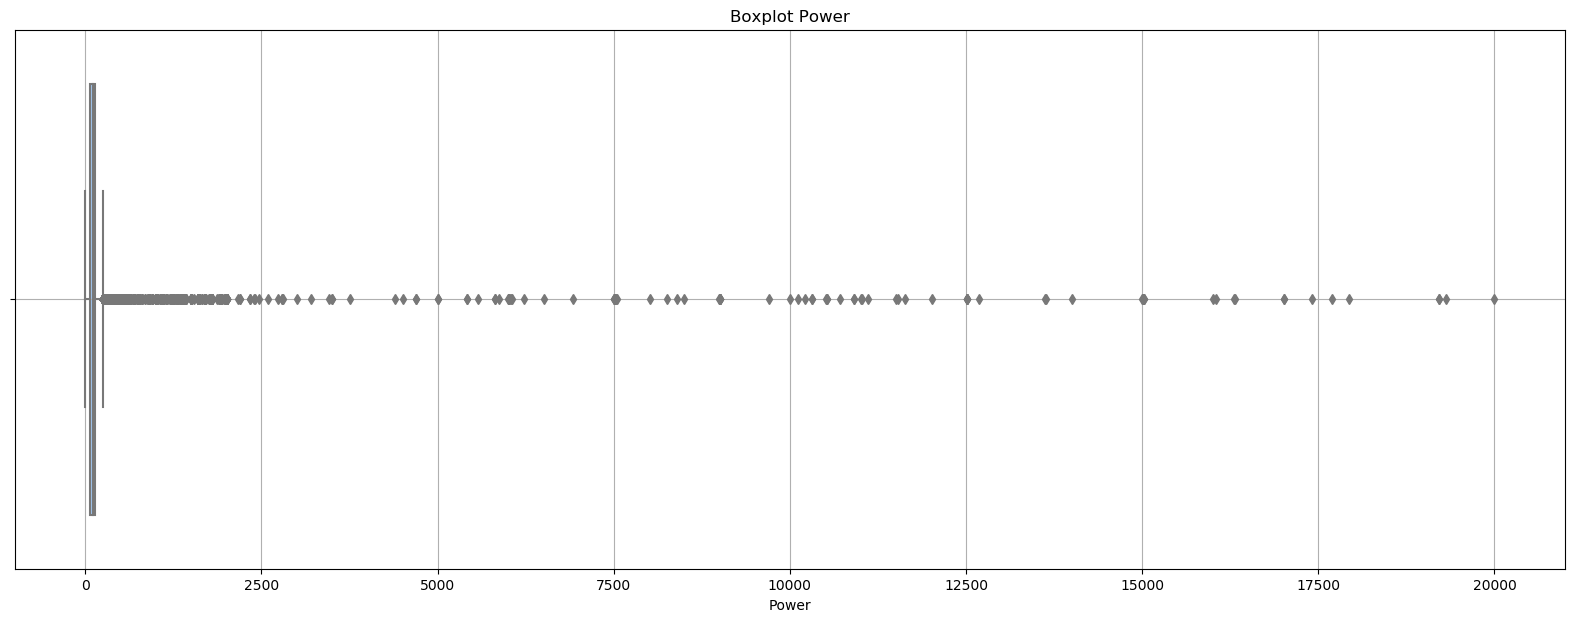

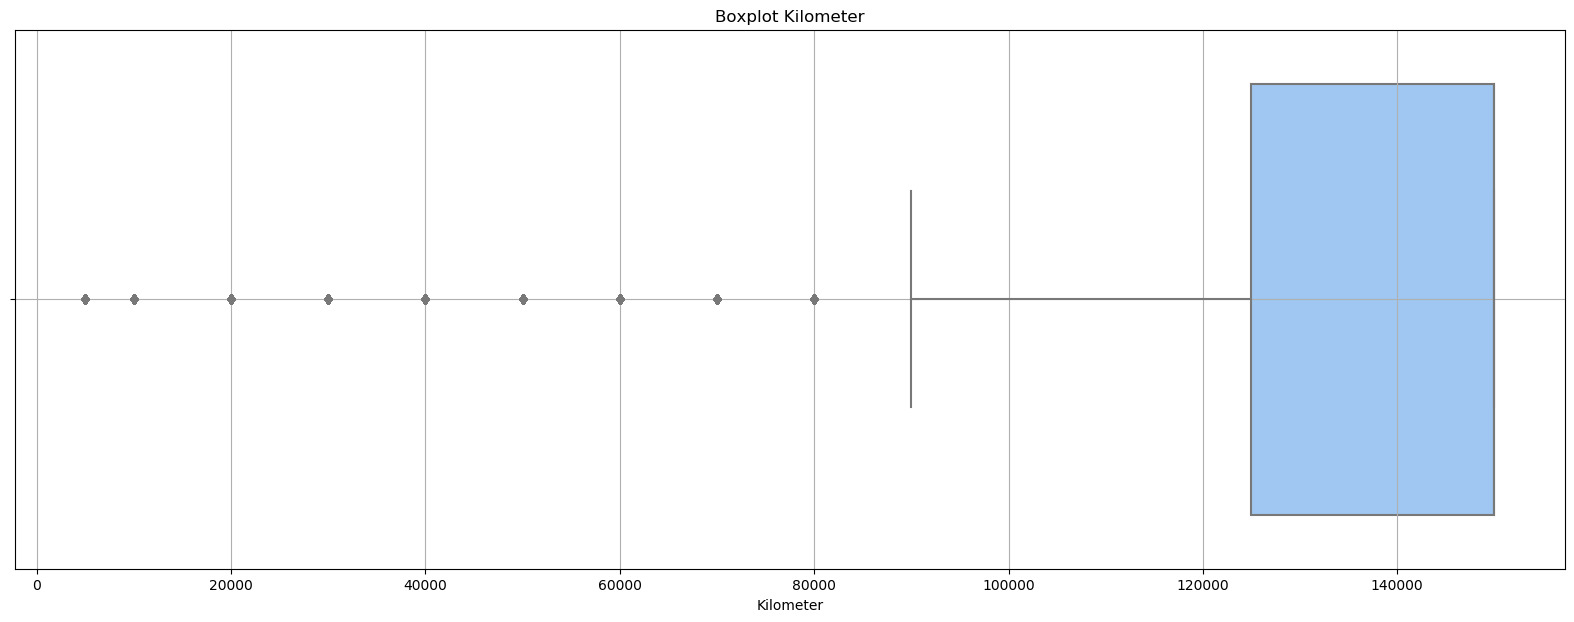

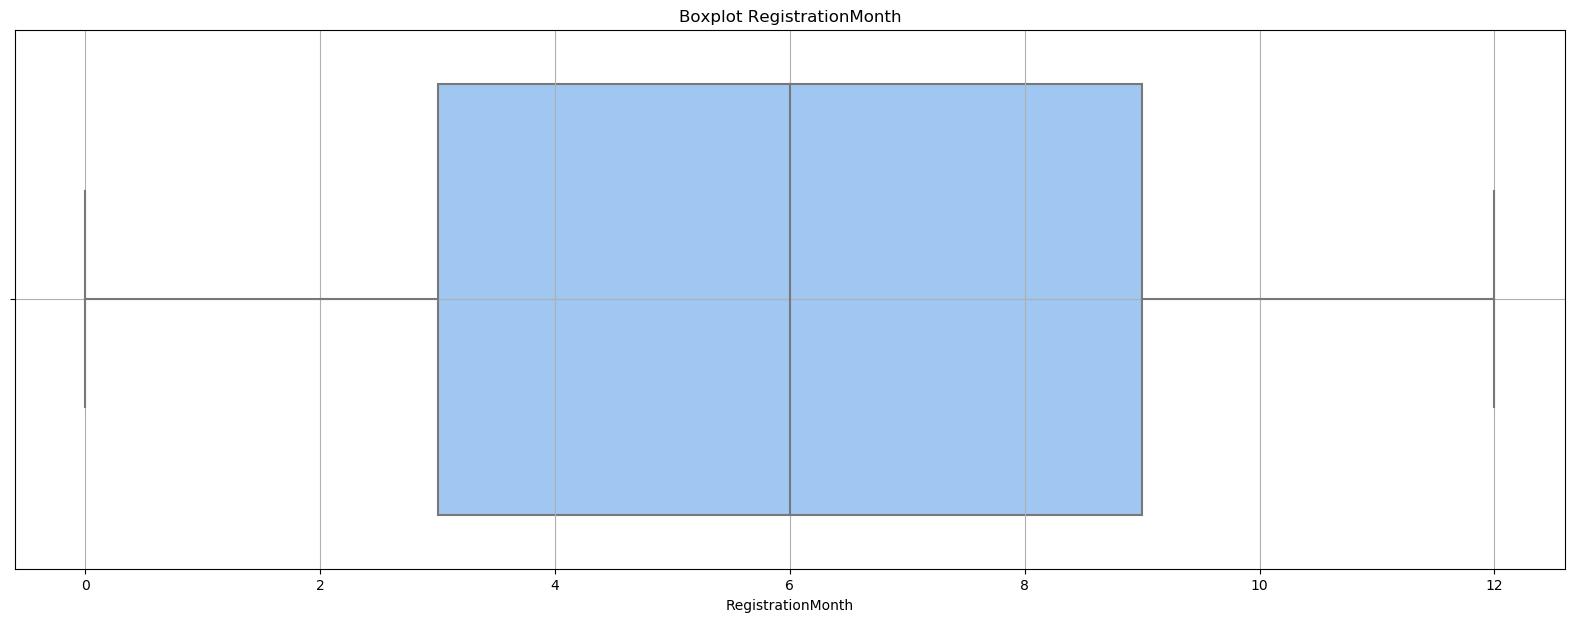

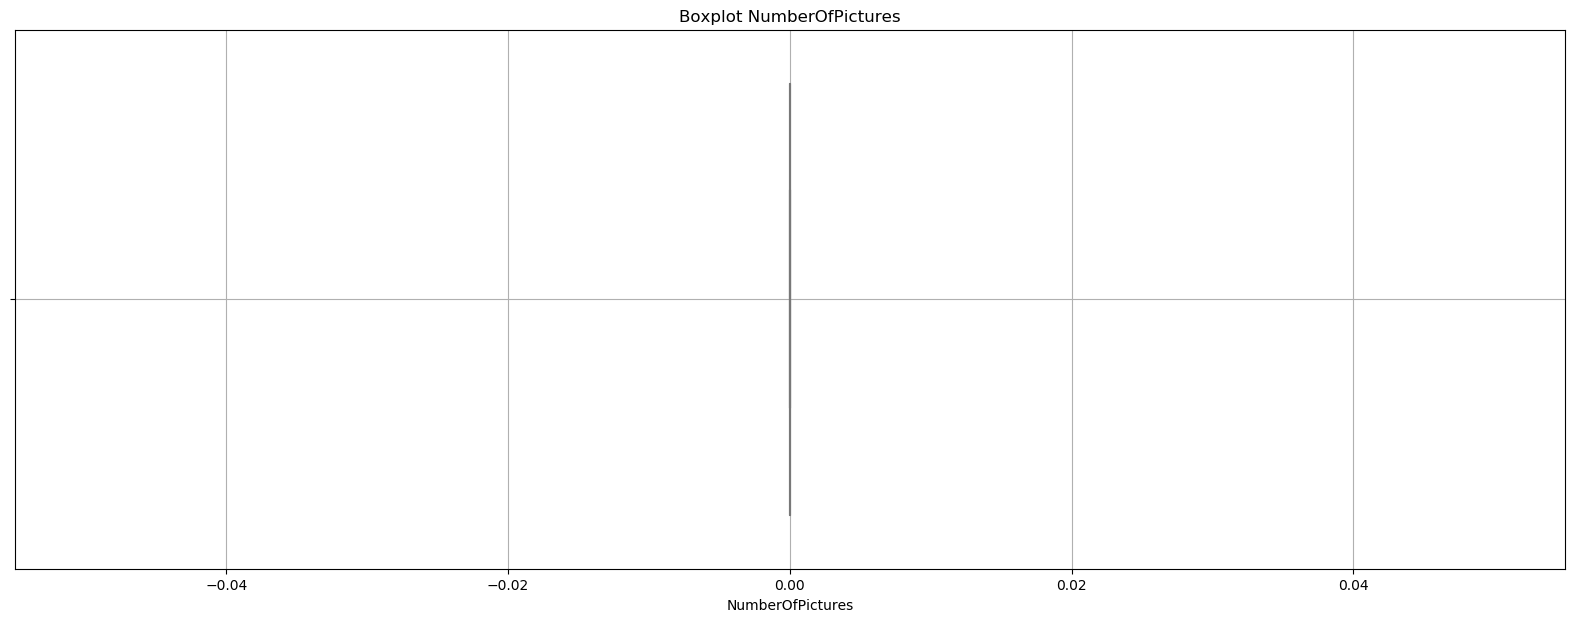

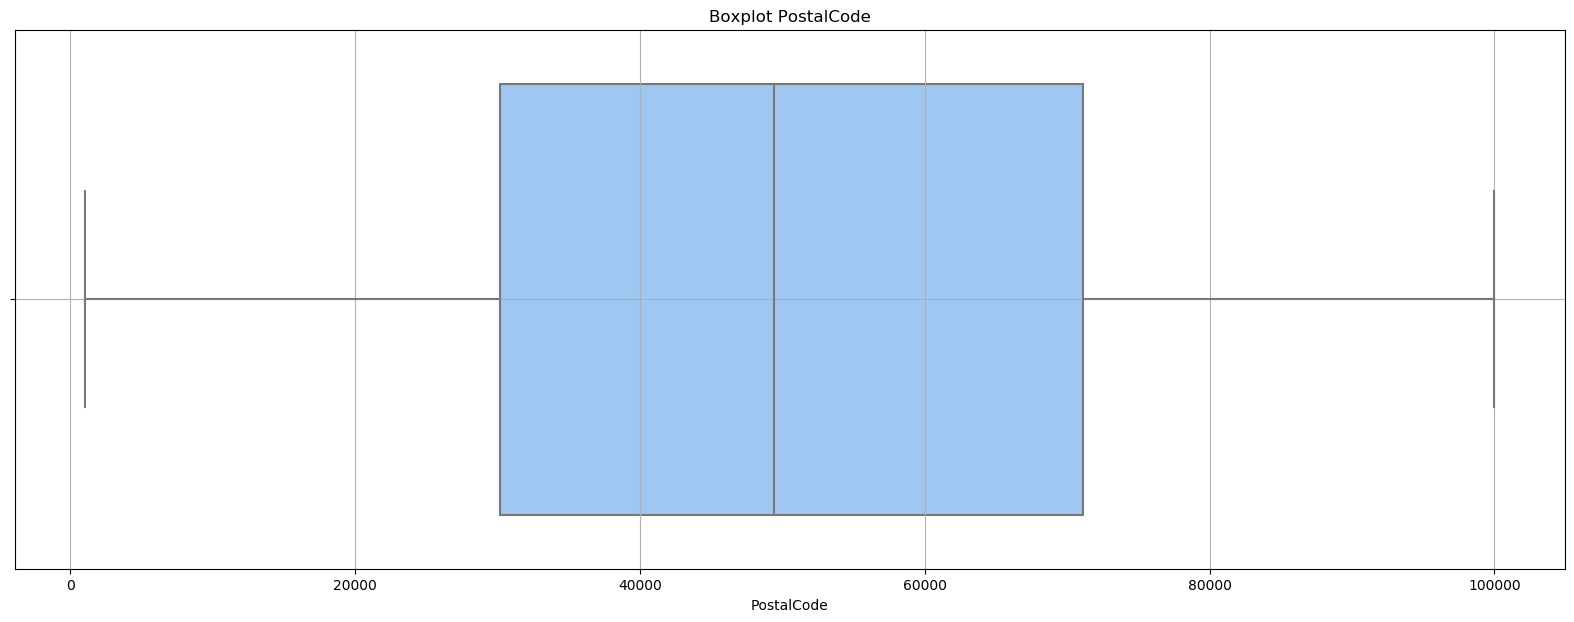

In [13]:
# С помощью bjxplot посмотрим на выбросы
for box in num_cols:
    plt.figure(figsize=(20, 7)) 
    sns.boxplot( x=data[box] )
    plt.grid()
    plt.title(f'Boxplot {box}', fontsize=12)

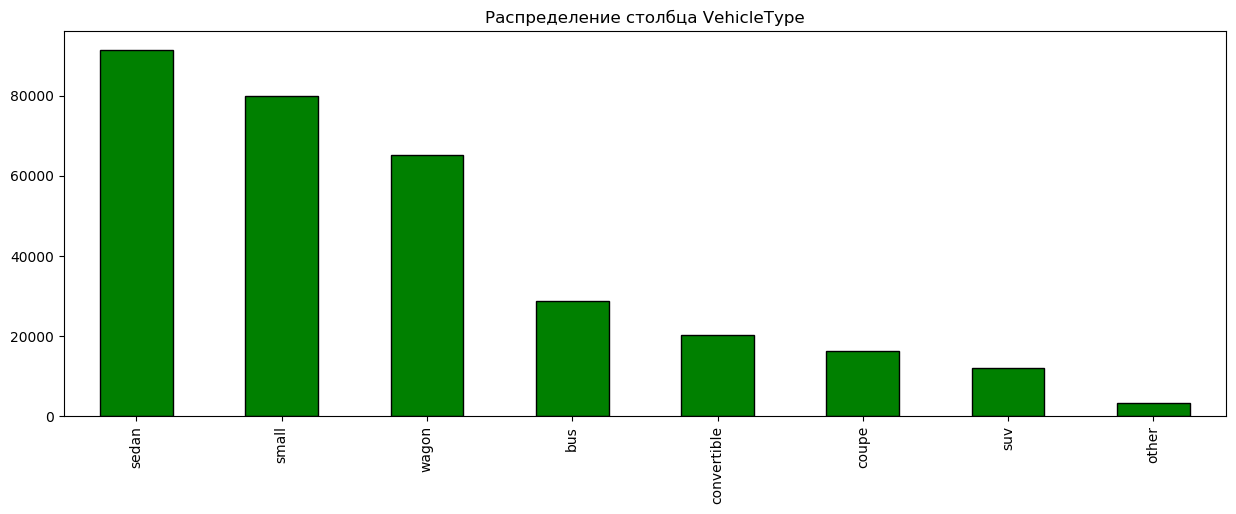

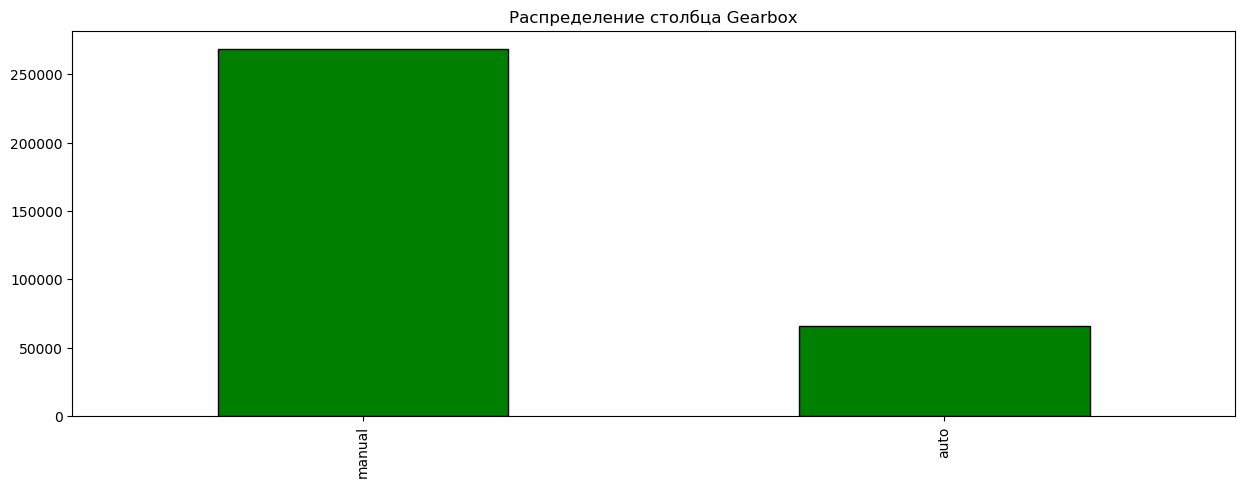

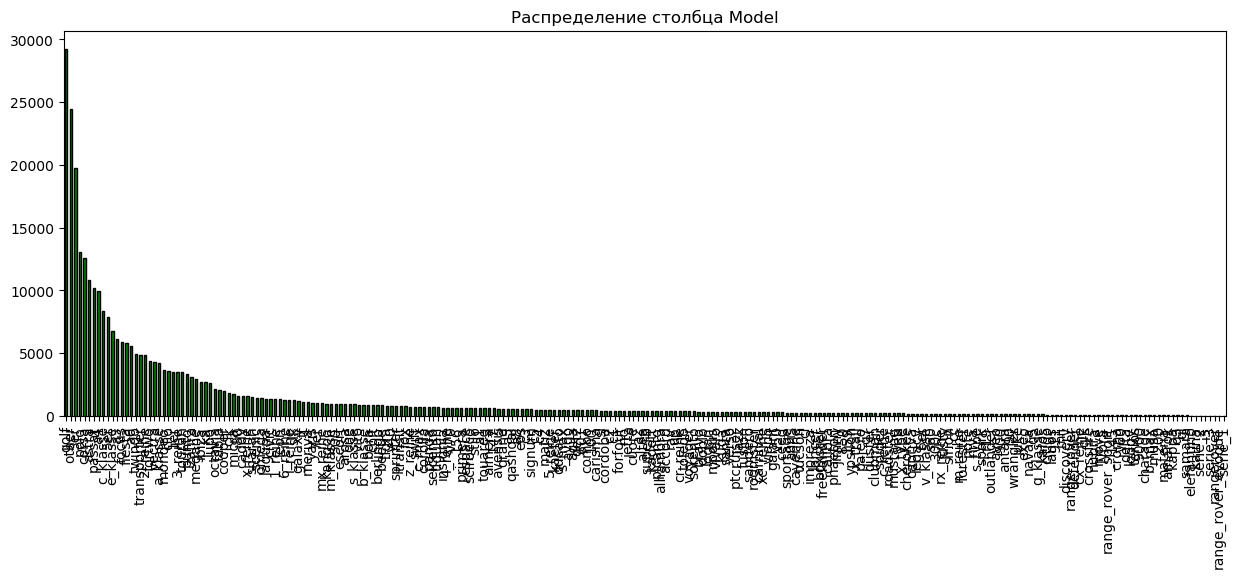

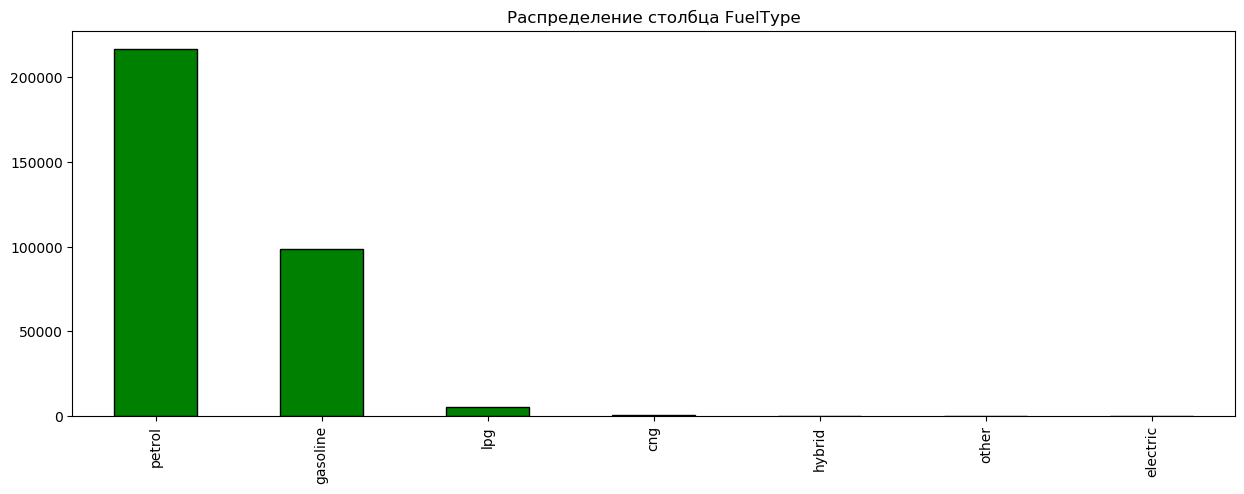

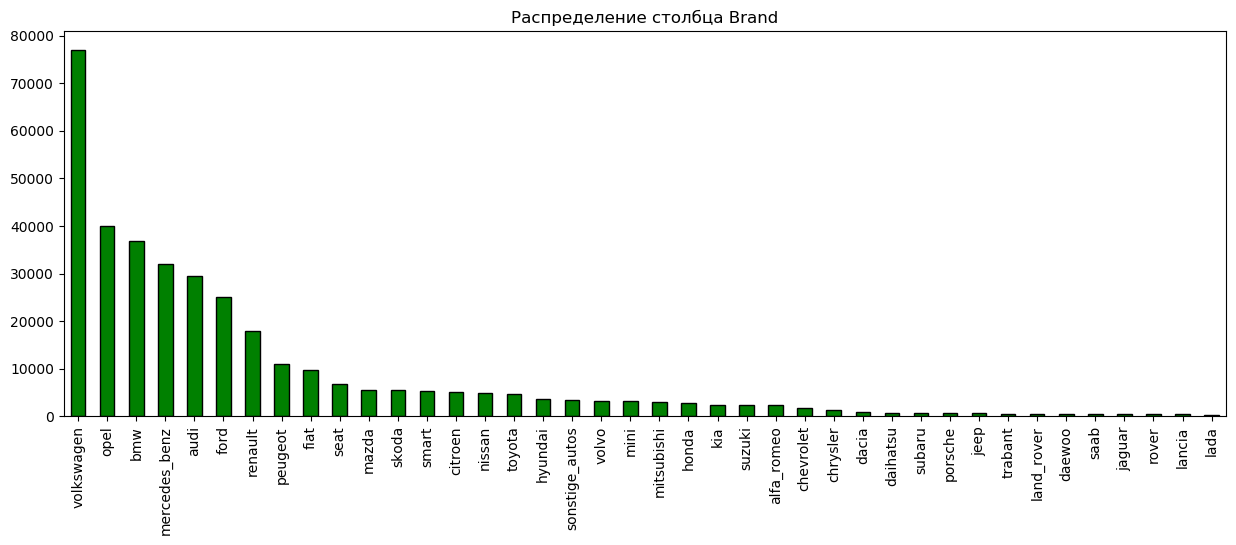

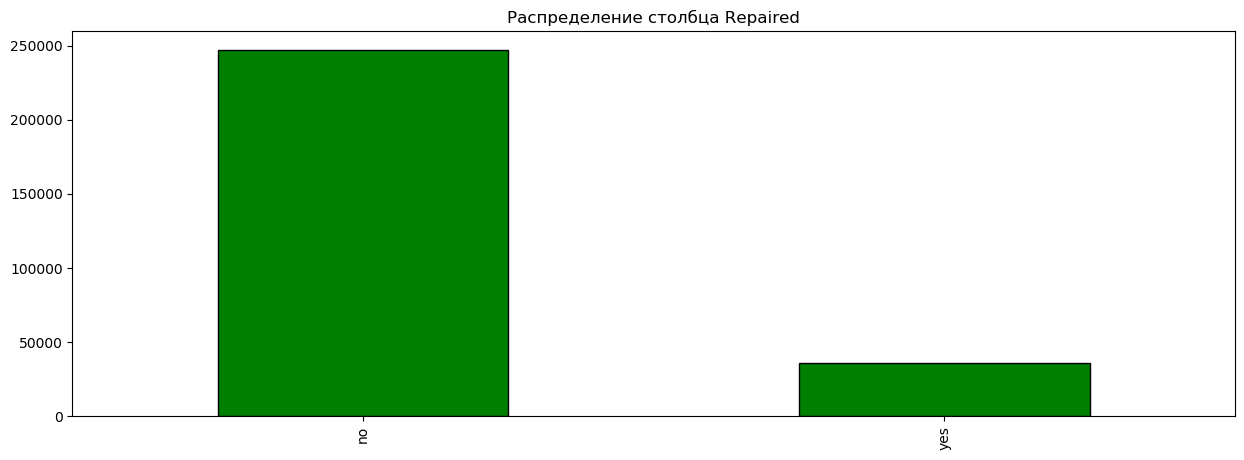

In [14]:
# распределение категориальных признаков
for column in cat_cols:
    plt.figure(figsize=(15,5))
    data[column].value_counts().plot.bar(color='green', edgecolor='k', rot=90)
    plt.title(f'Распределение столбца {column}')
    plt.show()

In [15]:
#Посмотрю пропуски
data.isna().sum().sort_values(ascending = False)

In [16]:
print('Уникальные значения в столбце Количество фотографий:', data['NumberOfPictures'].unique())

### Промежуточный вывод по анализу
- В числовых столбцах присутствуют выбросы, заметно в столбце с ценой и пробегом. 
- Обнаружены пропуски в категориальных столбцах. В столбце `Repaired` их целых 71 154
- В столбец `NumberOfPictures` (количество фотографий), заполнен нулями. Похоже, что при заполнении забыли внести туда число фотографий.

In [17]:
#Удалю столец с фотографиями, т.к. он не поможет обучать модель
data = data.drop(['NumberOfPictures'], axis=1)

In [18]:
#Т.к. присутствует большое количество пропусков, чтобы их не удалять, заполню пропуски в категориальных столбцах значением unknown
data = data.fillna('unknown')

In [19]:
data.isna().sum().sort_values(ascending = False)

### Обработка аномалий

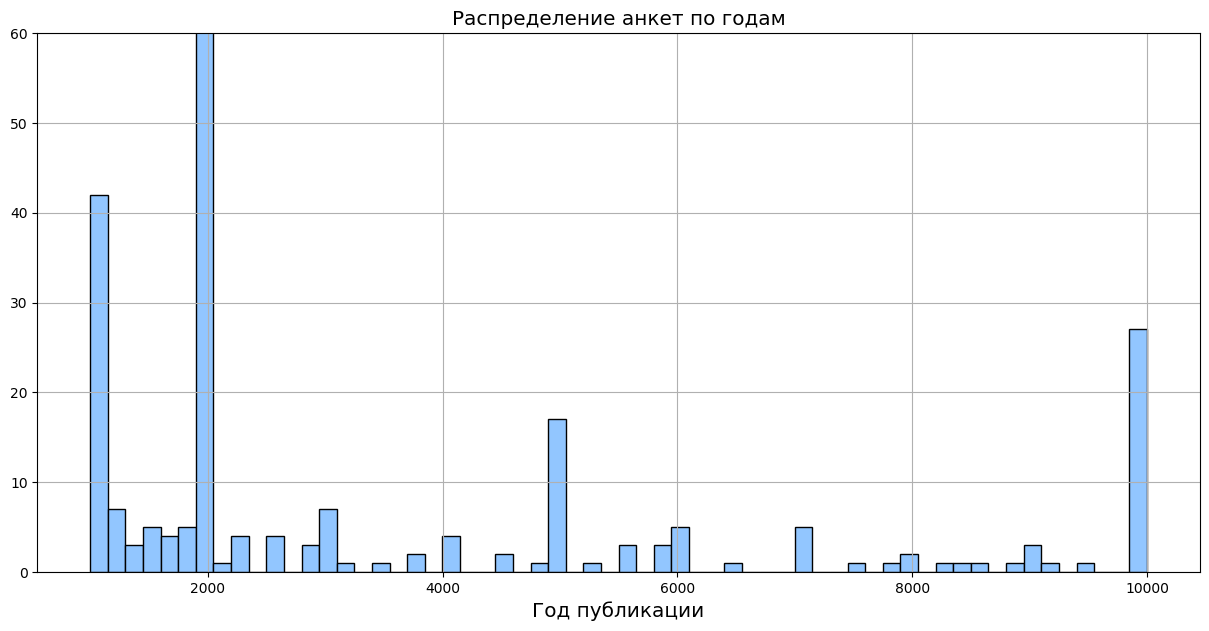

In [20]:
plt.figure(figsize=(15,7))
plt.ylim(0,60)
data['RegistrationYear'].hist(bins=60, edgecolor='k')
plt.title('Распределение анкет по годам', fontsize='x-large')
plt.xlabel('Год публикации', fontsize='x-large')
plt.show()

Выглядит странно. Посмотрю на уникальные года:

In [21]:
years = data['RegistrationYear'].unique()
years.sort()
years

С максимальным пределом года, всё понятно, это 2019, после него идут артефакты, посмотрю на минимальные года

In [22]:
data[data['RegistrationYear']<1960].sort_values(by ='RegistrationYear',  ascending = False).info()

Опытным путём, был выбран нижний предел `1960` год, если брать год больше, то туда будет попадать большое кол-во строк, что сильно укоротит датасет.

In [23]:
year_aft_max = data.query('RegistrationYear > 2016')
year_aft_min = data.query('RegistrationYear < 1960')

print('Количество строк, превышающих максимум:', year_aft_max['RegistrationYear'].count())
print('Количество строк, меньше минимума:', year_aft_min['RegistrationYear'].count())

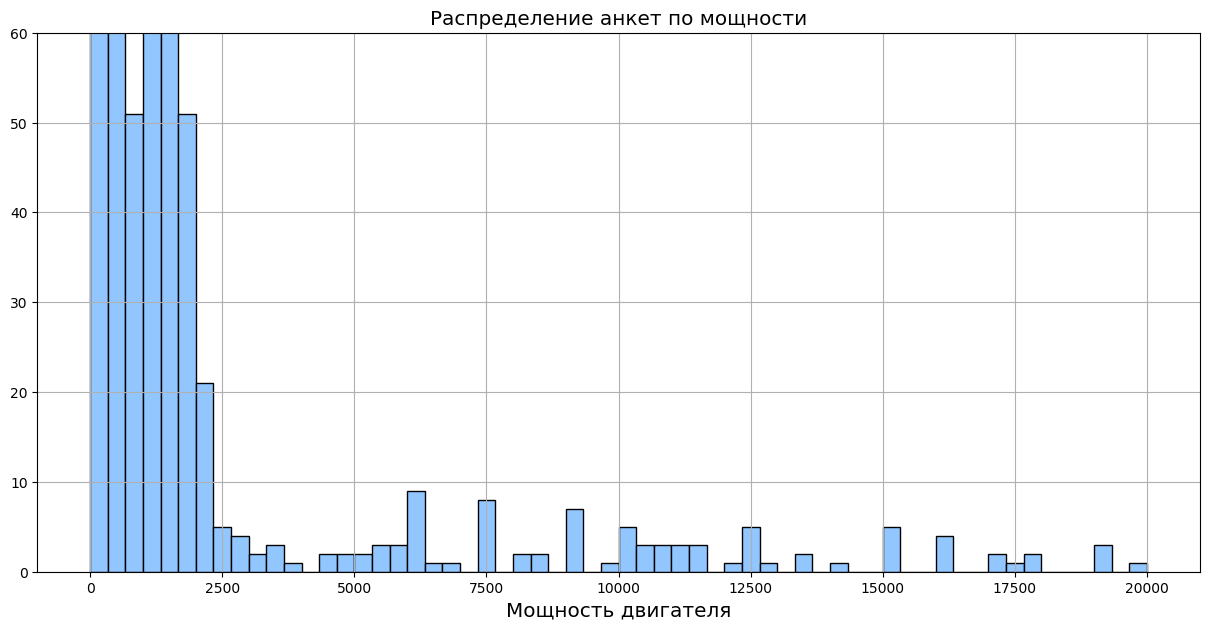

In [24]:
plt.figure(figsize=(15,7))
plt.ylim(0,60)
data['Power'].hist(bins=60, edgecolor='k')
plt.title('Распределение анкет по мощности', fontsize='x-large')
plt.xlabel('Мощность двигателя', fontsize='x-large')
plt.show()

In [25]:
power = data['Power'].unique()
power.sort()
power

Посмотрев в интернете, про мощности двигателей, было обнаружено, что:
- максимальную мощность имеет Dagger GT `2025` л.с. , но это очень дорогая машина, а мы рассматриваем автомобили для общего рынка, поэтому ограничемся максимальной мощностью в `800` л.с.

Фильтровать буду по этим пределам

In [26]:
power_aft_max = data[data['Power']>= 800]
print('Количество строк, превышающих максимум:', power_aft_max['Power'].count())

power_aft_min = data[data['Power'] < 30]
print('Количество строк, меньше минимума:', power_aft_min['Power'].count())

In [27]:
power_aft_min

Во многих строках, мощность двигателя равна 0, таких строк больше `41 133`, поэтому фильровать по минимуму я не буду

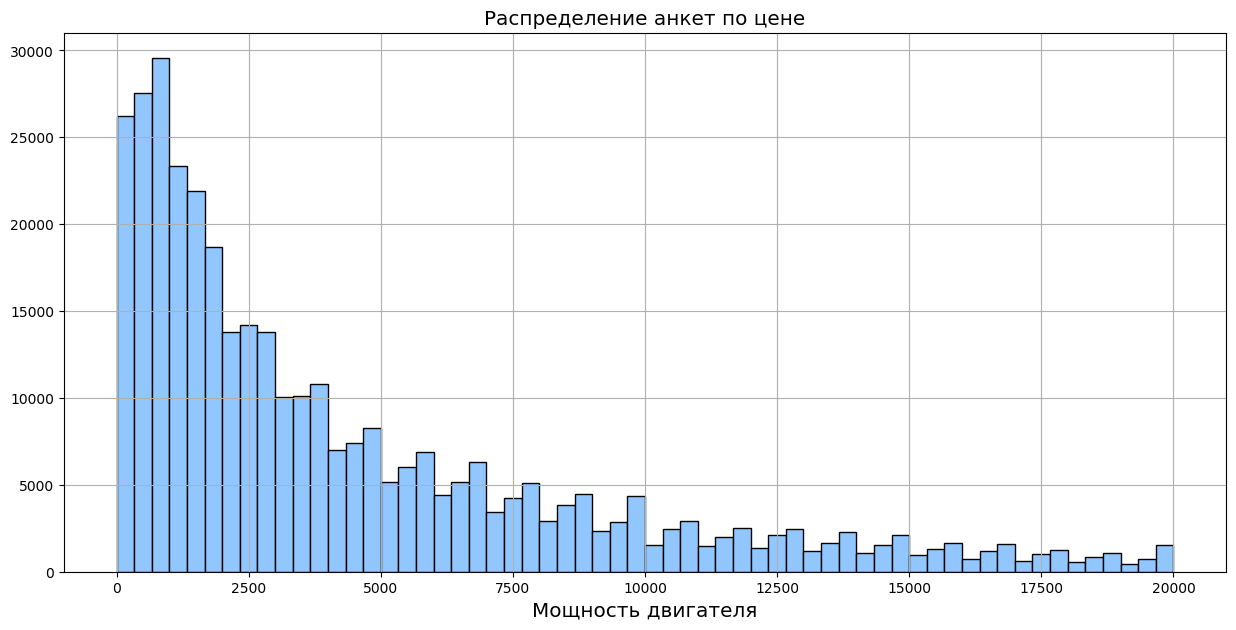

In [28]:
plt.figure(figsize=(15,7))
data['Price'].hist(bins=60, edgecolor='k')
plt.title('Распределение анкет по цене', fontsize='x-large')
plt.xlabel('Мощность двигателя', fontsize='x-large')
plt.show()

In [29]:
zero_price = data[data['Price'] == 0]
zero_price['Price'].count()

**Даты создания анкеты**

In [30]:
data.sort_values(by = 'DateCrawled', ascending = False)

**Вывод по дате создания анкеты**  
Получается, самая поздняя анкета дата скачивания анкеты с базы, Это 7 апреля 2016 год. Получается, что то, что больше этого значения, являетя аномалиями в годах регистрации, поэтому верхний предел я выставляю `2016` год.

**Рассмотрим столбец RegistrationMonth**

In [31]:
data['RegistrationMonth'].unique()

13 месяцев. Посмотрим на количество 12 и 0 месяцев

In [32]:
rm_0 = data[data['RegistrationMonth'] == 0].count()
rm_0['RegistrationMonth']

In [33]:
rm_12 = data[data['RegistrationMonth'] == 12].count()
rm_12['RegistrationMonth']

У 12 месячных меньше кол-во. И если подумать, что отсчёт в программировании начинаетася с 0, то 12 можно удалить

In [34]:
data = data.drop(data.query('Power > 800').index).reset_index(drop=True)
data = data.drop(data.query('RegistrationYear < 1960 or RegistrationYear > 2016').index).reset_index(drop=True)
data = data.drop(data.query('Price == 0').index).reset_index(drop=True)
data = data.drop(data.query('RegistrationMonth == 12').index).reset_index(drop=True)
data.info()

In [35]:
# Удалим столбцы, которые не в обучении

data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis=1)

In [36]:
#Ещё одна проверка на дубликаты
print('Дубликаты:',data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)

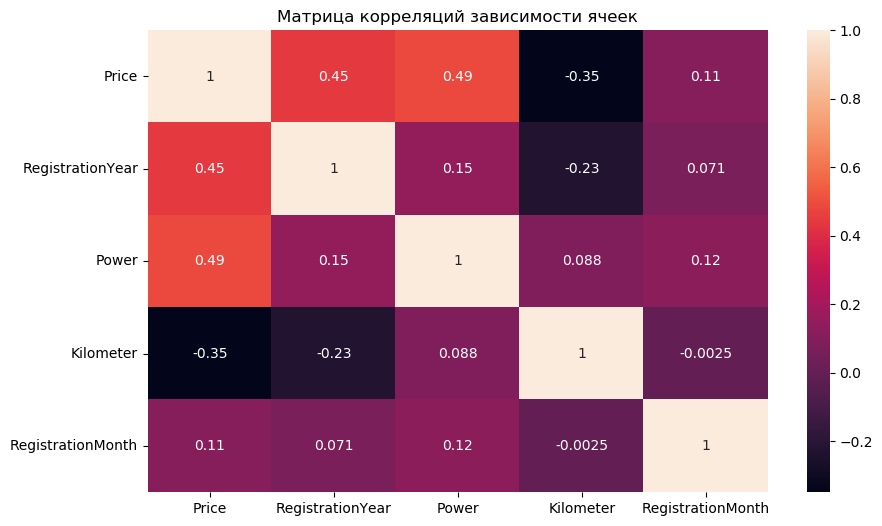

In [37]:
plt.figure(figsize=(10, 6))
plt.title('Матрица корреляций зависимости ячеек')
sns.heatmap(data.corr(), annot = True)
plt.show()

`Price` с `Power` имеет среднюю корреляцию, так же как `RegistrationYear`, остальные коррелируют не так сильно. Это может помочь с обучением модели

#### Вывод по обработке аномалий

- были обнаружены аномально высокие значения в колонке `Power`, значения больше 800 былы удалены
- в колонке `RegistrationYear` былы удалены значения меньше 1960 и больше 2016
- в колонке `Price` удалены строки, содержащие  значения 0
- в колонке `RegistrationMonth` было обнаружено 13 месяцев, месяца с нумирацией 12 были удалены, т.к. отсчёт начинается с 0

### Разделения на выборки

In [38]:
# Удаляю Model из списка категориальных столбцов
cat_cols.remove('Model')

In [39]:
# Использую метод OHE
data_ohe = pd.get_dummies(data, columns=cat_cols, drop_first=True)

data_ohe.info()

In [40]:
# Разделяю выборку на тренировочную и тестувую
train, test = train_test_split(data,
                               test_size=0.20,
                               random_state=12345)

In [41]:
train.info()

In [42]:
# Модели закодируем через Target Encoder
target_en = TargetEncoder()

target_en.fit(train['Model'], train['Price'])
train['Model'] = target_en.transform(train['Model'])
test['Model'] = target_en.transform(test['Model'])

In [43]:
# Объединяю выборки
train = pd.concat([train, data_ohe.drop(train.columns.drop(cat_cols), axis=1)], 
                  join='inner', 
                  axis=1)
test = pd.concat([test, data_ohe.drop(test.columns.drop(cat_cols), axis=1)], 
                 join='inner', 
                 axis=1)

train = train.drop(cat_cols, axis=1)
test = test.drop(cat_cols, axis=1)

In [44]:
print('Размер тренировочной выборки:', train.shape,
      '\nРазмер тестовой выборки:', test.shape)

In [45]:
train_features = train.drop('Price', axis=1)
train_target = train['Price']

test_features = test.drop('Price', axis=1)
test_target = test['Price']

num_cols = ['Kilometer', 'Power', 'RegistrationYear', 'RegistrationMonth', 'Model']
scaler = StandardScaler()
scaler.fit(train_features[num_cols]) 

train_features[num_cols] = scaler.transform(train_features[num_cols])
test_features[num_cols] = scaler.transform(test_features[num_cols])

Данные разделены

## Обучение моделей

Для обучения возьму все те модели, которые изучали до этого, линейная регрессия, дерево решенийб случайный лес, а так же использую градиентный бустинг.

### Линейная регрессия

In [46]:
# Делим на выборки
train_features, valid_features, train_target, valid_target = train_test_split(train_features, 
                                                                              train_target,
                                                                              test_size=0.25,
                                                                              random_state=12345)

In [47]:
Linear_reg = LinearRegression()

start = time()
Linear_reg.fit(train_features, train_target)
predicted = Linear_reg.predict(valid_features)
Linear_reg_time_fit = time() - start

print('Время обучения модели: {:0.2f} секунд'.format(Linear_reg_time_fit),
      '\nRMSE на валидационной выборке:', mean_squared_error(valid_target, predicted)**0.5)

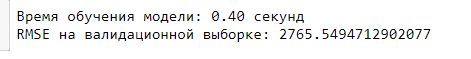

Для ускорения обработки данных воспользуюсь RandomizedSearchCV. Он подбирает наилучшие гиперпараметры для моделей. Передавать модели и параметры можно с помощью списка. Для его использования нужно объединить выборки.

In [48]:
train_features = pd.concat([train_features, valid_features])
train_target = pd.concat([train_target, valid_target])

In [49]:
# Создам пустой датафрейм, куда будут записываться полученные результаты

models_list = pd.DataFrame({'model':[], 'RMSE':[], 'time_to_predict':[], 'studying_time':[] })
all_models = []

In [50]:
def train_model(model, parameters):
    
    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=100, 
                                      scoring='neg_mean_squared_error', # используем необходимую метрику
                                      cv=3, 
                                      verbose=1, 
                                      random_state=12345)
    
    # считаем время обучения
    start = time()
    model_random.fit(train_features, train_target)
    print('RandomizedSearchCV подбирает параметры %.2f за секунд' %(time() - start))
    
    start = time()
    model_random.best_estimator_.fit(train_features, train_target)
    studying_time = time() - start
    print('Модель обучается %.2f за секунд' %studying_time)
    
    start = time()
    model_random.predict(train_features)
    time_to_predict = time() - start
    print('Модель предсказывает за %.2f секунд' %time_to_predict)
    
    # высчитаем метрики
    rmse = (model_random.best_score_ * -1) ** 0.5
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    
    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, time_to_predict, studying_time])
    models_list.loc[len(models_list.index)] = row
    
    return model_random, rmse

### Дерево решений

In [51]:
tree_rnd_param = {"max_depth": list(range(10, 15))}

model_tree = DecisionTreeRegressor()

tree_param, tree_rmse = train_model(model_tree, tree_rnd_param) # обучим и сохраним значения


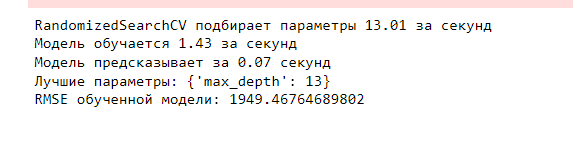

### Случайный лес

In [52]:
# зададим рандомные параметры

ran_grid_forest = {
    'max_depth': [12, 13, 14],
    'n_estimators': [200, 300]
}

rfr = RandomForestRegressor(n_jobs=-1)

rfr_random, rmse_rfr = train_model(rfr, ran_grid_forest)

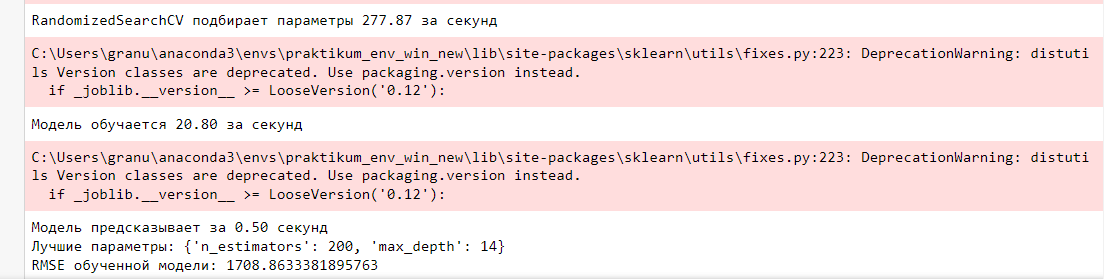

### LightGBM:

In [54]:
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random, rmse_gbm = train_model(gbm, rand_lgbm_param)

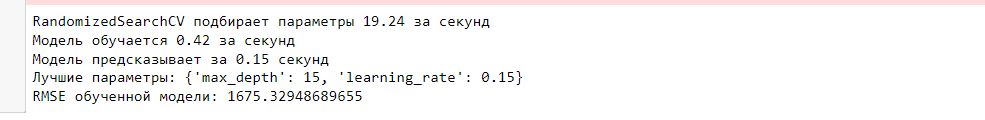

### XGBoost:

In [55]:
rand_xgb_param = {
    'max_depth': [11, 12, 13,],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True)

xb_random, rmse_xb = train_model(xb, rand_xgb_param)

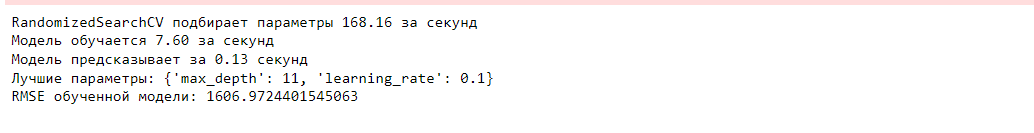

### CatBoost:

In [58]:
rand_cat_param = {
    'max_depth': [10, 11, 12, 13],
    'learning_rate': [0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False, 
                        task_type='CPU')

cat_random, rmse_cat = train_model(cat, rand_cat_param)

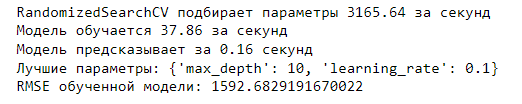

## Анализ моделей

In [59]:
all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([models_list, all_names], axis=1, join='inner')
display(analisys)

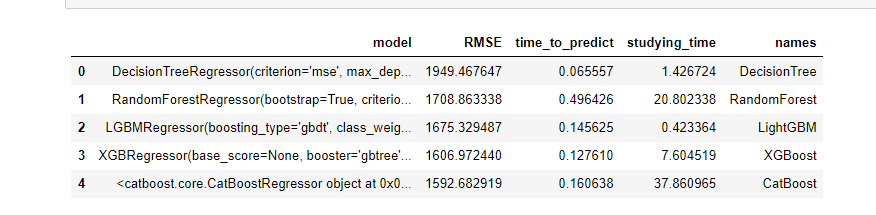

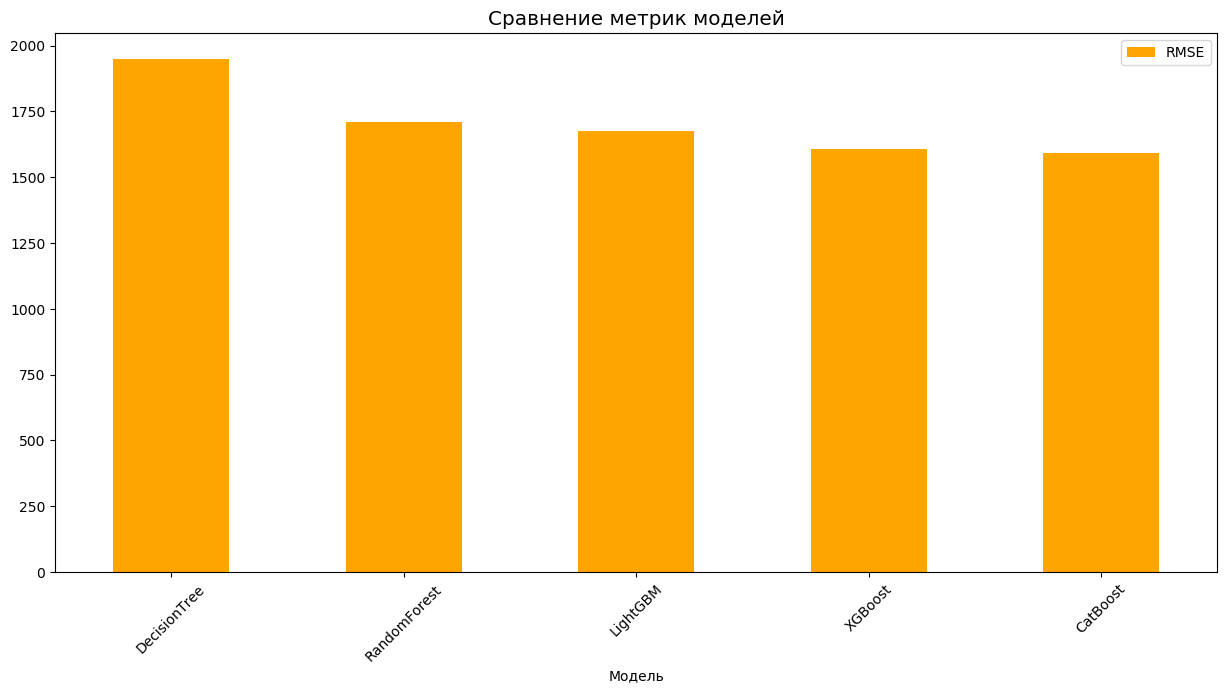

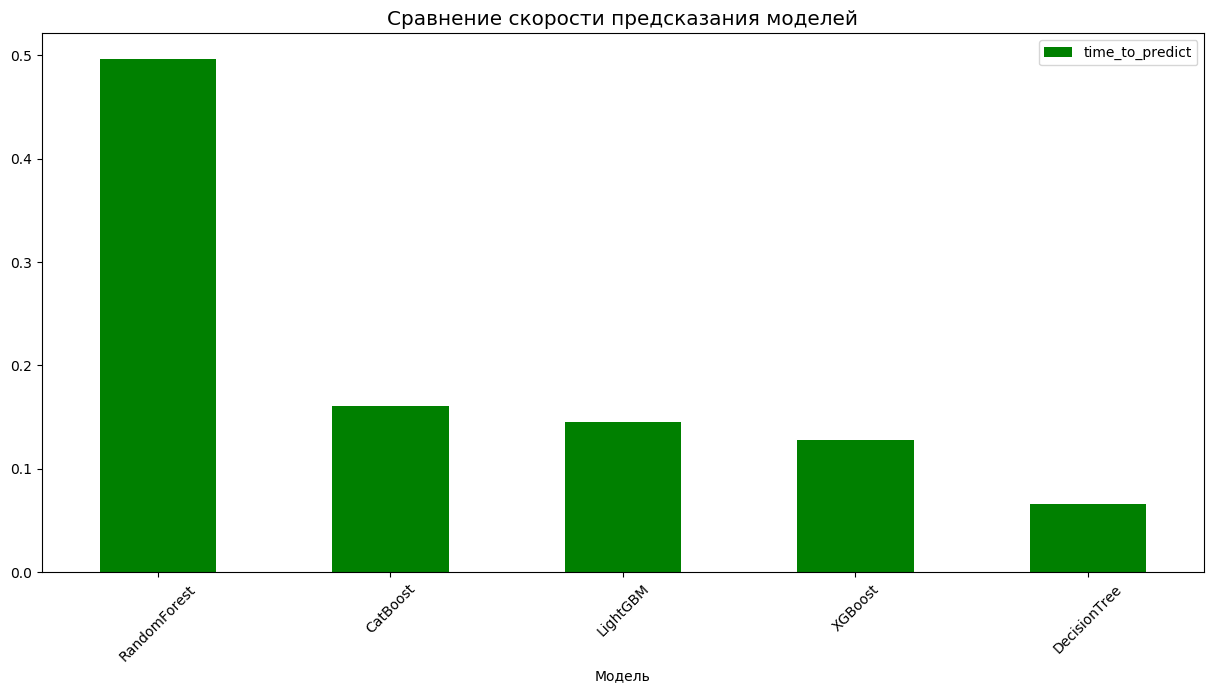

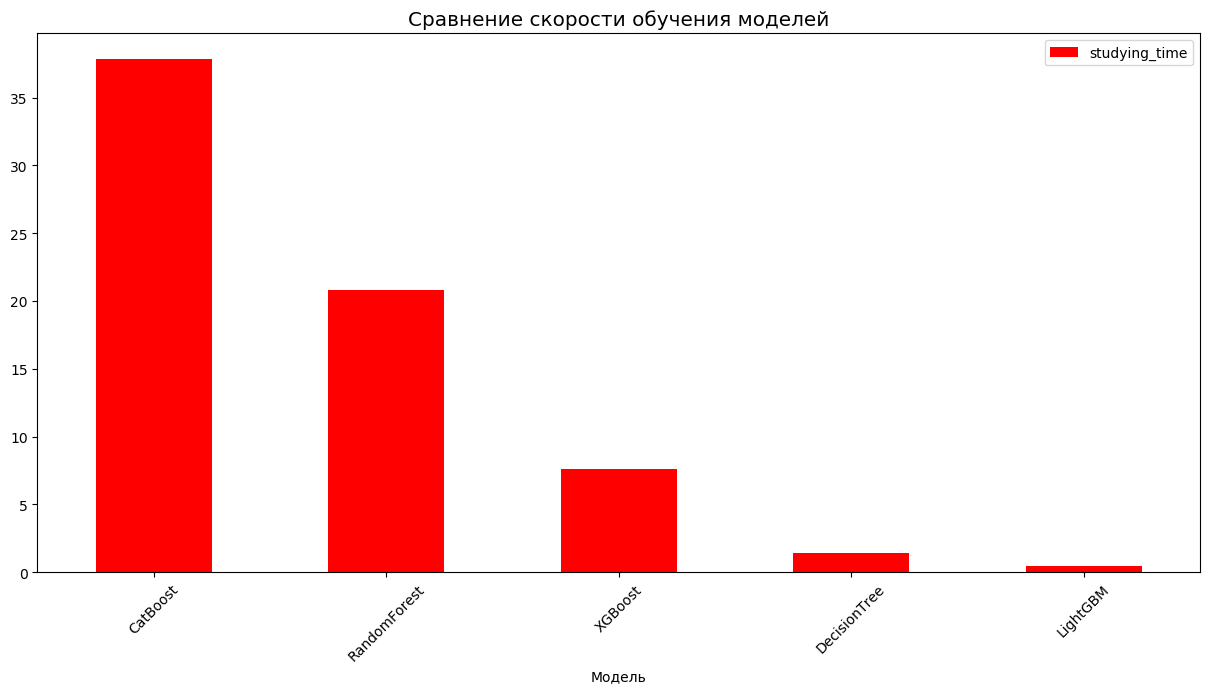

In [60]:
analisys.plot.bar(y='RMSE', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.sort_values(by='time_to_predict', ascending=False)\
.plot.bar(y='time_to_predict', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение скорости предсказания моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.sort_values(by='studying_time', ascending=False)\
.plot.bar(y='studying_time', x='names', rot=45, figsize=(15,7), color='red')
plt.title('Сравнение скорости обучения моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()


### Вывод по анализу моделей

- самой худшей моделью, по метрики `RMSE`, оказалась линейная регрессия, у неё значение `RMSE` = 2765
- По метрикам остальные модели справились хорошо, самая низкая `RMSE` у `CatBoost`, высокая у `DecisionTree`
- по времени предсказания самой быстрой оказалась `DecisionTree`,самой медленной - `RandomForest`
- по скорости обучения, самая медленная `CatBoost`, самая быстрая `LightGBX`
- по итогу выбираем самую быструю и точную модель, это `XGBoost`

Проверка на тестовой выборке

In [61]:
start = time()
predicted = xb_random.predict(test_features)
print('Модель предсказывает не тестовой выборке за %.2f секунд' %(time() - start))

rmse_on_test = mean_squared_error(test_target, predicted)
print('Итоговый RMSE на тестовой выборке:', rmse_on_test**0.5)